In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [2]:
M = 2                # the population has two age groups
N = 1e5              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

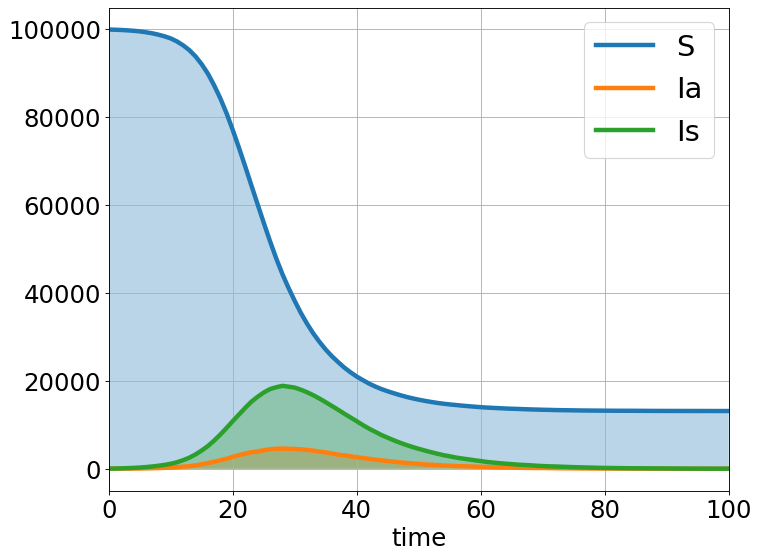

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')/N

In [5]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"]]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

In [6]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni/N, Omega=N, lyapunov_method='euler')

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)
print(logp) 

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
173.57036308307391


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'betaIa':{
        'mean': 0.005, 
        'std': 0.003, 
        'bounds': [eps, 0.1]
    }, 
    'betaIs':{
        'mean': 0.02,  
        'std': 0.02, 
        'bounds': [eps, 0.1]
    }, 
    'gIa':{
        'mean': 0.2, 
        'std': 0.1,
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': 0.15,
        'std': 0.1, 
        'bounds': [eps, 0.6]
    }
}

Ia0_g = x[0, M:2*M]
Ia0_std = Ia0_g
Ia0_b = np.array([[0.1, 100]]*M)/N

S0_g = x[0, :M]
S0_std = Ia0_std*3
S0_b = np.divide([(100, N) for N in Ni], N) 

init_priors = {
    'independent':{
        'fltr': np.repeat([True, True, False], M), 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S0_std, *Ia0_std], 
        'bounds': [*S0_b, *Ia0_b]
    }
}


# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  
estimator.set_lyapunov_method('euler')
res = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, 
                                    contactMatrix=contactMatrix, 
                                    tangent=False, global_max_iter=100, global_atol=1, local_max_iter=10000,
                                    verbose=True, ftol=ftol) 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=3300342478, Thu Aug 27 11:57:58 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.581207658076948e+02 1.0e+00 1.11e+00  2e-04  1e-01 0:00.3
    2     32 1.404414374655069e+02 1.2e+00 1.04e+00  2e-04  1e-01 0:00.7
    3     48 1.343813957784688e+02 1.4e+00 8.90e-01  2e-04  9e-02 0:01.0
   11    176 1.532593318720493e+02 2.0e+00 5.75e-01  9e-05  6e-02 0:04.1
   25    400 1.348926169101511e+02 9.3e+00 4.36e-01  7e-05  4e-02 0:08.2
   42    672 1.318792534441966e+02 3.5e+01 2.38e-01  4e-05  2e-02 0:13.4
   62    992 1.311320413283098e+02 1.6e+02 2.36e-01  3e-05  1e-02 0:19.6
   71   1136 1.310749444950756e+02 1.1e+02 2.82e-01  4e-05  1e-02 0:22.3
Optimal value (global minimisation):  131.02610870786117
Starting local minimisation...
Optimal value (local minimisation):  130.91594948003316


In [8]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['params_dict']
print(best_estimates)

print('\nTrue inits')
print((x0*N).astype('int'))

print('\n Inferred inits')
print((res['x0']*N).astype('int'))

True parameters:
{'betaIa': 0.004, 'betaIs': 0.016, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285}

Inferred parameters:
{'betaIa': 0.003651382363483225, 'betaIs': 0.01677549420546017, 'gIa': 0.13937581458627413, 'gIs': 0.15093158560501796}

True inits
[24960 74960    20    20    20    20]

 Inferred inits
[24959 74945     7     7    32    32]


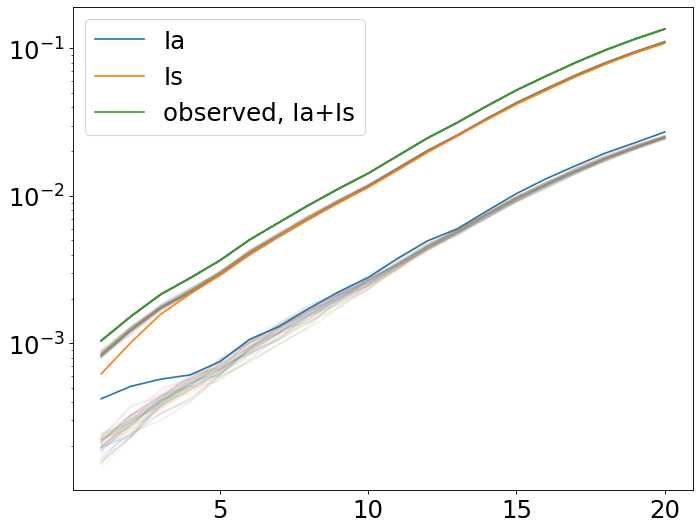

In [9]:
nsamples = 40 
trajs = estimator.sample_trajs(obs, fltr, Tf_inference, res, nsamples, contactMatrix=contactMatrix)
t = np.linspace(1, Tf_inference, Nf_inference-1)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
for i in range(nsamples): 
    plt.semilogy(t, np.sum(trajs[i, :, M:2*M], axis=1), alpha=0.1)
    plt.semilogy(t, np.sum(trajs[i, :, 2*M:3*M], axis=1), alpha=0.1)
    plt.semilogy(t, np.sum(trajs[i, :, M:3*M], axis=1), alpha=0.1)
plt.semilogy(t, np.sum(data_array[1:Nf_inference, M:2*M], axis=1)/N, label='Ia')
plt.semilogy(t, np.sum(data_array[1:Nf_inference, 2*M:3*M], axis=1)/N, label='Is')
plt.semilogy(t, np.sum(data_array[1:Nf_inference, M:3*M], axis=1)/N, label='observed, Ia+Is')
plt.legend()
plt.show()   

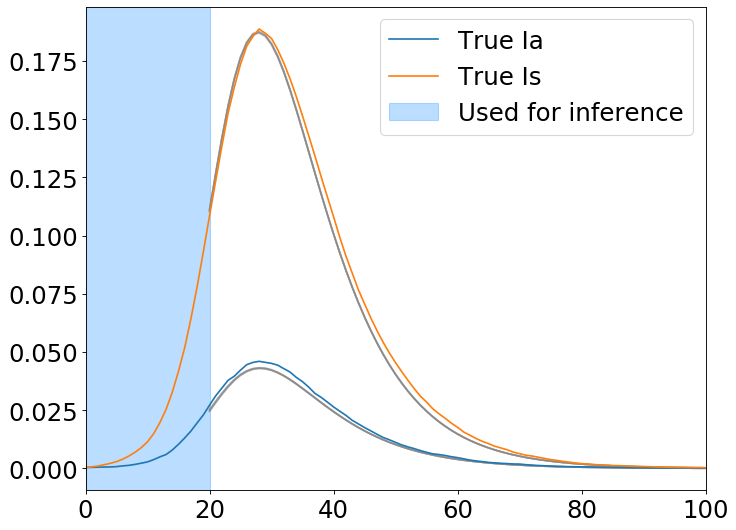

In [10]:
samples = estimator.sample_endpoints(obs, fltr, Tf_inference, res, 20, contactMatrix=contactMatrix)
time_points = np.linspace(0, Tf, Nf)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
for x_start in samples: 
    xm = estimator.integrate(x_start, Tf_inference, Tf, Nf-Tf_inference, dense_output=False)
    plt.plot(time_points[Tf_inference:], np.sum(xm[:, M:2*M], axis=1), color='grey', alpha=0.1)
    plt.plot(time_points[Tf_inference:], np.sum(xm[:, 2*M:3*M], axis=1), color='grey', alpha=0.1)
    
plt.plot(time_points, np.sum(data_array[:, M:2*M], axis=1)/N, label='True Ia')
plt.plot(time_points, np.sum(data_array[:, 2*M:3*M], axis=1)/N, label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend() 
plt.show()

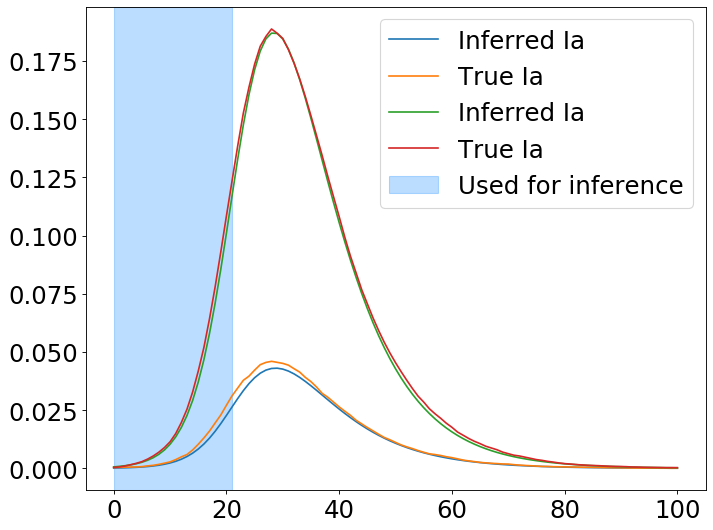

In [11]:
Nf = 101
Tf = Nf-1

map_x0 = res['x0']

estimator.set_params(best_estimates)
x_det = estimator.integrate(map_x0, 0, Tf, Nf)
x = data['X']
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
# plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
# plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1)/N, label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1)/N, label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 